In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
file = 'Rellis_3D_lidar_example-2/os1_cloud_node_kitti_bin/000000.bin'
cloud = np.fromfile(file, dtype=np.float32)
cloud = cloud.reshape((-1, 4))
cloud.shape

(131072, 4)

In [5]:
xyz = cloud[:, :3]
x = cloud[:, 0]
y = cloud[:, 1]
z = cloud[:, 2]
ref = cloud[:, 3:]

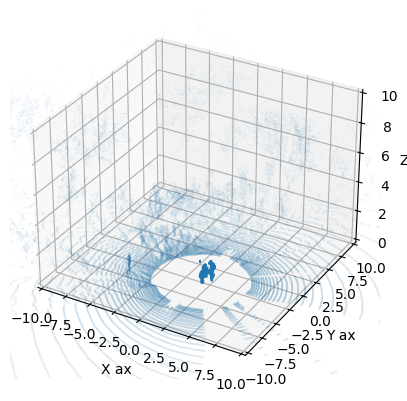

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z,s=0.001)

ax.set_xlabel('X ax')
ax.set_ylabel('Y ax')
ax.set_zlabel('Z ax')

ax.set_xlim([-10, 10]) 
ax.set_ylim([-10, 10])  
ax.set_zlim([0, 10]) 

plt.show()

In [26]:
H = 64
W = 1024

fov_up = np.pi / 8 # 45 / 2 deg
fov_down = -np.pi / 8
fov = np.abs(fov_up) + np.abs(fov_down)

# convert to spherical coords
rad = np.linalg.norm(xyz, 2, axis=1) # radius of points from origin
rad[rad == 0] = 1e-4 # adjust origin to make warping work

yaw = -np.arctan2(y, x) # phi
pitch = np.arcsin(z / rad) # theta

# (rad, yaw, pitch)
# now map to 2d image of yaw x pitch
# yaw goes [-pi, pi] and pitch goes [fov_down, fov_up]
proj_x_unit = 0.5 * (yaw / np.pi + 1.0) # scaled to [0,1]
proj_y_unit = 1.0 - (pitch + np.abs(fov_down)) / fov # scaled to [0,1]
proj_x = proj_x_unit * W # [0, W]
proj_y = proj_y_unit * H # [0, H]

# convert to indices
proj_x = np.floor(proj_x)
proj_x = np.minimum(W - 1, proj_x)
proj_x = np.maximum(0, proj_x).astype(np.int32)

proj_y = np.floor(proj_y)
proj_y = np.minimum(H - 1, proj_y)
proj_y = np.maximum(0, proj_y).astype(np.int32)

In [27]:
u = proj_x.copy()
v = proj_y.copy()
u, v

(array([512, 512, 512, ..., 515, 508, 502], dtype=int32),
 array([32, 32, 32, ..., 53, 54, 55], dtype=int32))

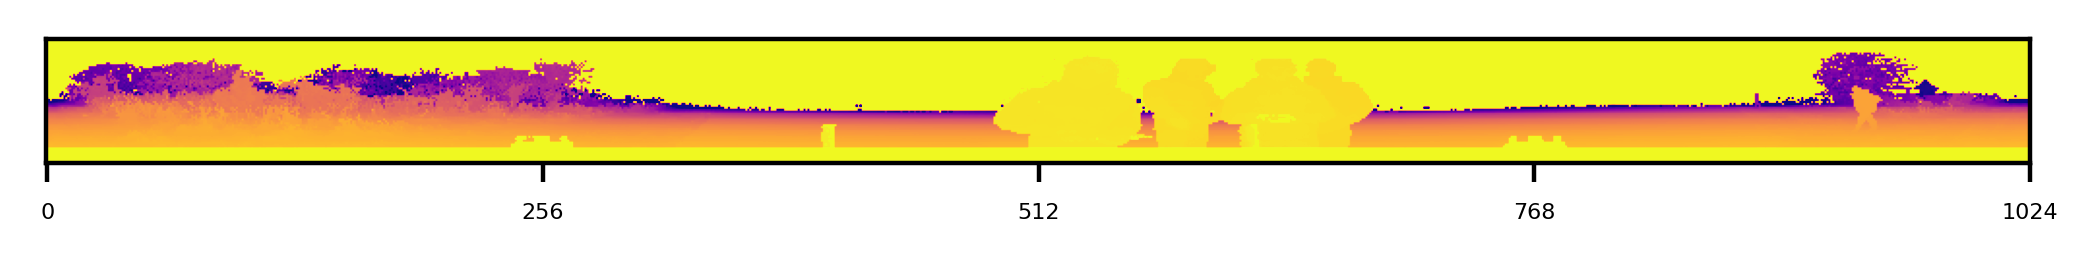

In [72]:
panorama = np.full((H, W), -1, dtype=np.float32)
panorama[v, u] = rad

# Note, origin is top left corner

plt.figure(dpi=400)
plt.imshow(panorama, cmap='plasma_r', vmin=0, vmax=30)
ax = plt.gca()
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([0,256,512,768,1024])
ax.set_xticklabels([0,256,512,768,1024], fontsize=4)
plt.show()

In [94]:
label_file = 'Rellis_3D_lidar_example-2/os1_cloud_node_semantickitti_label_id/000000.label'
labels = np.fromfile(label_file, dtype=np.int32)
labels = labels.reshape((-1))
sem_labels = labels & 0xFFFF # extract sem label (other part is instance id)
sem_labels.shape

(131072,)

In [95]:
label_color_def = {
    0: (255, 0, 0),   # Red
    3: (0, 255, 0),   # Green
    4: (0, 0, 255),   # Blue
    5: (255, 255, 0), # Yellow
    19: (255, 0, 255),# Magenta
    31: (0, 255, 255),# Cyan
    33: (128, 128, 128) # Gray
}
color_map = np.zeros((33 + 1, 3), dtype=np.uint8)
for label, color in label_color_def.items():
    color_map[label] = color

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


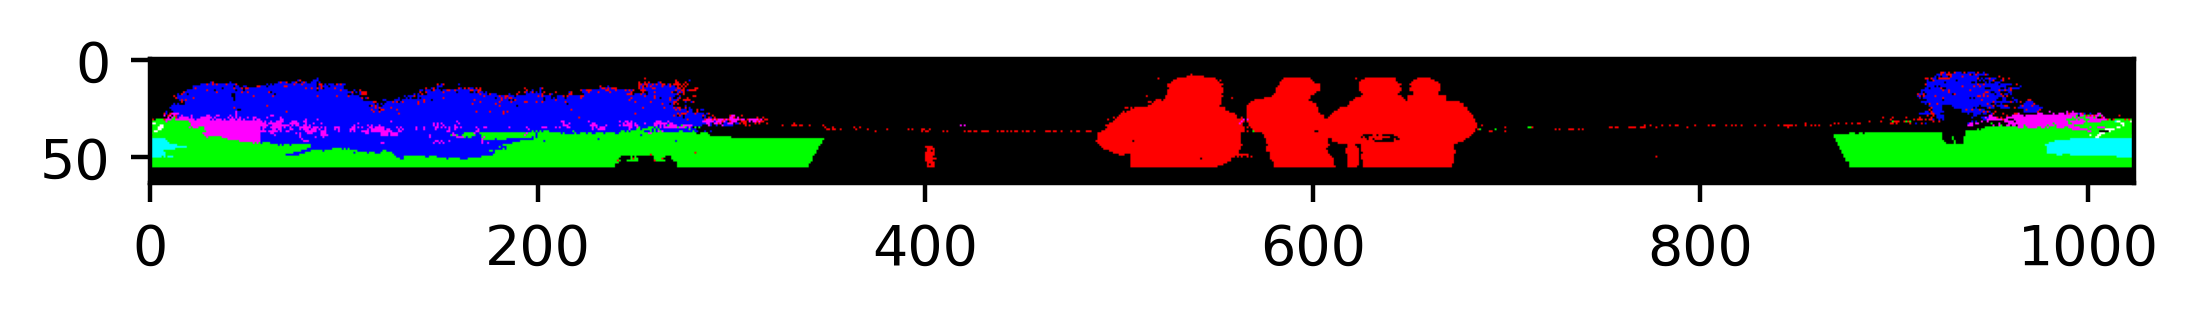

In [96]:
sem_panorama = np.full((H, W, 3), 0, dtype=np.float32)
sem_panorama[v, u] = color_map[labels]

plt.figure(dpi=400)
plt.imshow(sem_panorama)